# Tweet sentiment analysis: model performance comparison

In this notebook we will be testing several deep learning model configurations to find the best performing one on our set of 40.000 positive and 40.000 negative tweets.

We will be attempting to guess positive (1) or negative (0) sentiment in a tweet.

In [2]:
# import necessary librairies

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from wordcloud import WordCloud

import nltk
import emoji
import preprocessor as p

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import time
import pickle

from keras.utils import pad_sequences
from keras.layers import Flatten, LSTM, Embedding, Dense, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Sequential

# download important nltk packages

nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')

# save requirements

!pip freeze > requirements.txt

from helpers import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\fabia\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fabia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fabia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Exploring the data

In [64]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", delimiter=",", encoding = "ISO-8859-1", header=None)
data = data[[0, 5]]
data = data.rename(columns={0: "target", 5: "tweet"})
data = data.replace({"target":{4:1}})
data

,target,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


[Text(0.5, 1.0, 'Distribution of positive (1) and negative (0) tweets')]

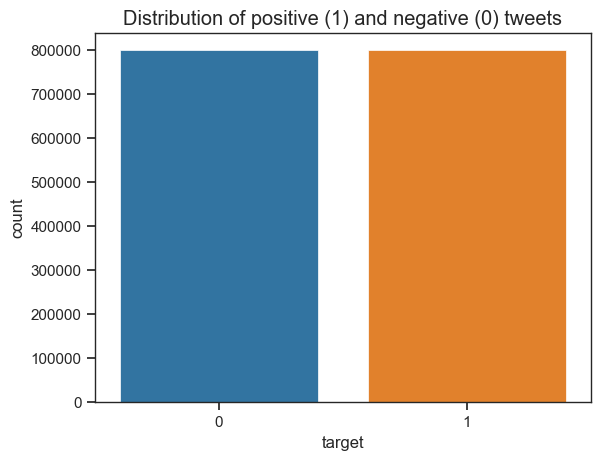

In [65]:
sns.set_style("ticks")
sns.countplot(x=data.target, palette="tab10").set(title="Distribution of positive (1) and negative (0) tweets")

In [67]:
# we will use a sample of 20,000 positive tweets and 20,000 negative tweets

sample_df = pd.DataFrame()

for target in [0,1]:
    target_df = data[data["target"] == target].sample(20000, random_state=42)
    sample_df = sample_df.append(target_df, ignore_index=True)

sample_df

,target,tweet
0,0,@xnausikaax oh no! where did u order from? tha...
1,0,A great hard training weekend is over. a coup...
2,0,"Right, off to work Only 5 hours to go until I..."
3,0,I am craving for japanese food
4,0,Jean Michel Jarre concert tomorrow gotta work...
...,...,...
39995,1,LOL MY BUSINESS or MY WORK ACTUALLY (totally ...
39996,1,Sims 3 is amazing to tell you all!
39997,1,@jodiekearns we splashed out on an awning a fe...
39998,1,I HAVE A NEW CAR! ... it is in Florida.


### WordClouds

In [47]:
sample_df["clean_tweet"] = sample_df["tweet"].apply(lambda row : text_cleaner(row)).apply(lambda x : " ".join(x))

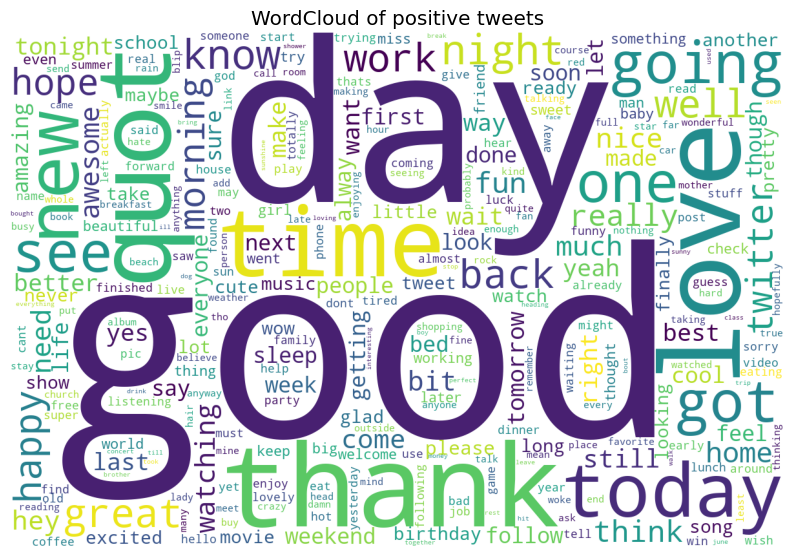

In [54]:
positive_tweets = sample_df[sample_df["target"]==4]["clean_tweet"]

plt.figure(figsize=(10,8))
wordcloud = WordCloud(max_words=300, width=1200, height=800, background_color='white',
                        collocations=False).generate(" ".join(positive_tweets))
plt.grid(None)
plt.title("WordCloud of positive tweets")
plt.axis('off')
plt.imshow(wordcloud)

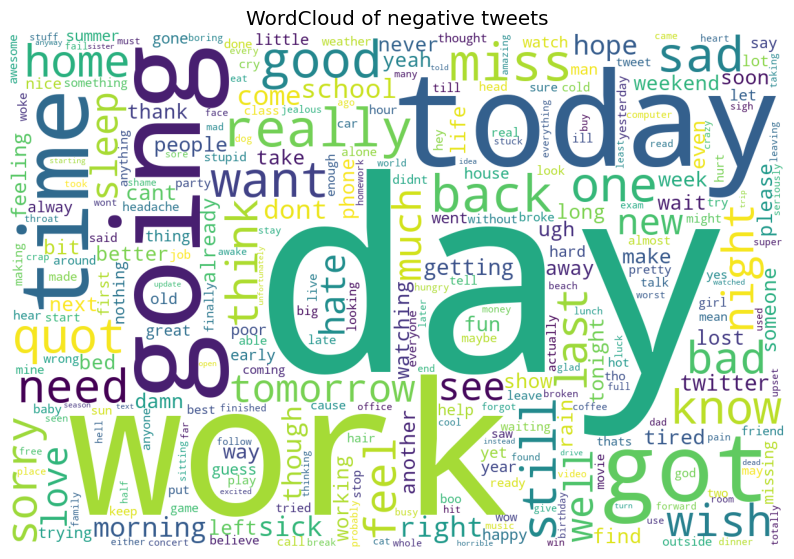

In [55]:
negative_tweets = sample_df[sample_df["target"]==0]["clean_tweet"]

plt.figure(figsize=(10,8))
wordcloud = WordCloud(max_words=300, width=1200, height=800, background_color='white',
                        collocations=False).generate(" ".join(negative_tweets))
plt.grid(None)
plt.title("WordCloud of negative tweets")
plt.axis('off')
plt.imshow(wordcloud)

## Baseline: Logistic Regression with TF-IDF vectorizer

In [57]:
X = sample_df["clean_tweet"]
y = np.array(sample_df["target"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Splitting done.")
print("Shape of training set: " + str(X_train.shape))
print("Shape of test shape: " + str(X_test.shape))
print("Count of training target values: " + str(np.unique(y_train, return_counts=True)))
print("Count of test target values: " + str(np.unique(y_test, return_counts=True)))

Splitting done.
Shape of training set: (28000,)
Shape of test shape: (12000,)
Count of training target values: (array([0, 4], dtype=int64), array([14003, 13997], dtype=int64))
Count of test target values: (array([0, 4], dtype=int64), array([5997, 6003], dtype=int64))


Time to train vectorizer and transform training text: 3.04s
Model evaluation:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      5997
           4       0.71      0.75      0.73      6003

    accuracy                           0.72     12000
   macro avg       0.72      0.72      0.72     12000
weighted avg       0.72      0.72      0.72     12000



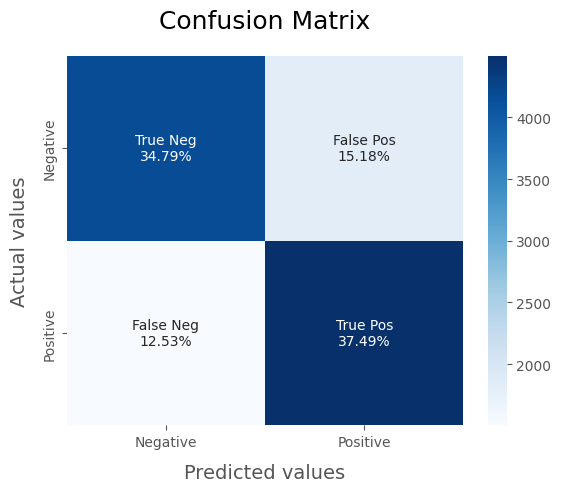

In [58]:
classification_model = LogisticRegression(max_iter=1000, n_jobs=-1)
tfidfconverter = TfidfVectorizer(max_features=500000, min_df=5, max_df=0.7, ngram_range=(1,2))

tfidfconverter.fit(X_train)

start = time.time()

# model = Pipeline([ ("vectorizer", tfidfconverter),
#                    ("classifier", classification_model)])

X_train = tfidfconverter.transform(X_train)
X_test = tfidfconverter.transform(X_test)

classification_model.fit(X_train, y_train)

end = time.time()

predictions = classification_model.predict(X_test)

print('Time to train vectorizer and transform training text: %0.2fs' % (end - start))
print('Model evaluation:')
model_Evaluate(classification_model, X_test, y_test)

In [59]:
print("Number of positive predictions: " + str(predictions.tolist().count(0)))
print("Number of negative predictions: " + str(predictions.tolist().count(4)))

Number of positive predictions: 5679
Number of negative predictions: 6321


In [61]:
file = open('tfidf_vectoriser.pickle', 'wb')
pickle.dump(tfidfconverter, file)
file.close

file = open('Sentiment-LR.pickle', 'wb')
pickle.dump(classification_model, file)
file.close()

In [62]:
predict(["I love twitter", "I hate twitter", "I'm in an excellent mood", "This is terrible news"])

,text,sentiment
0,I love twitter,Positive
1,I hate twitter,Negative
2,I'm in an excellent mood,Positive
3,This is terrible news,Negative


## Deep learning with Keras

### Embeddings: wiki2vec and GloVe

In [3]:
embeddings_dictionary_w2vec = dict()
w2vec_file = open('G:\enwiki_20180420_win10_100d.txt', encoding='utf-8')

for line in w2vec_file:
    records = line.strip().split(' ')
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary_w2vec[word] = vector_dimensions
w2vec_file.close()

In [33]:
embeddings_dictionary_glove = dict()
glove_file = open('G:\glove.twitter.27B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary_glove[word] = vector_dimensions
glove_file.close()

In [37]:
df = pd.read_csv("https://raw.githubusercontent.com/katrinmisel/sentiment_analysis/master/sample_df.csv")

In [7]:
def deep_model_test(data, text_prep_function, embedding, model_type, output_filename):

  # input:  data = dataframe containing a "tweet" column and a "target" column
  #         text_prep_function = 'homemade', 'tweet_preprocessor' or 'none'
  #         embedding = 'w2vec' or 'glove'
  #         model_type = 'simple' or 'advanced'
  #         output_filename = model at best performance will be saved as .h5 file with this filename ex. "simple_model.h5"

  # output: at [0] will be [output_filename, loss, accuracy, training_time]
  #         at [1] will be the tokenizer created with the preprocessing and embedding choice

  print(output_filename)
  performances = []

  # split in X and y (target)

  if (text_prep_function == 'homemade'): # if the model uses our handmade function
    X = np.array(data.tweet.apply(lambda x: text_cleaner(x)))
  elif (text_prep_function == 'tweet_preprocessor'): # if the model uses the tweet preprocessor python library
    X = np.array(data.tweet.apply(lambda x: p.clean(x)))
  else:
    X = np.array(data.tweet) #  no preprocessing at all

  y = np.array(data.target)

  # train test split with 30% test size

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # tokenize with keras

  keras_tokenizer = Tokenizer(num_words=5000)
  keras_tokenizer.fit_on_texts(X_train)

  # transform texts to sequences

  X_train = keras_tokenizer.texts_to_sequences(X_train)
  X_test = keras_tokenizer.texts_to_sequences(X_test)

  # pad sequences to the same length (100)
  # use pre padding instead of post padding for better performance (post often adds noise)

  X_train = pad_sequences(X_train, padding='pre', maxlen=100)
  X_test = pad_sequences(X_test, padding='pre', maxlen=100)

  vocab_size = len(keras_tokenizer.word_index) + 1

  if (embedding=='glove'): # create a GloVe embedding matrix

    embedding_matrix = np.zeros((vocab_size, 100))
    for word, index in keras_tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary_glove.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
  
  else: # create a Wiki2Vec embedding matrix

    embedding_matrix = np.zeros((vocab_size, 100))
    for word, index in keras_tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary_w2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

  # both our models are sequential keras models with a first embedding layer with the embedding matrix we created as weights

  model = Sequential()
  embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=100, trainable=False)
  model.add(embedding_layer)

  # if model is simple, add a Flatten and a Dense layer

  if (model_type == 'simple'):
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # else if model is advanced, add a bidirectional LSTM layer and a Dense layer

  else:
    # !!! since we are using dropout, our training accuracy will be lower than our validation accuracy
    model.add(Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.2))) 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # use callbacks: earlystopping and modelcheckpoint that saves our model at its best performance

  es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=0)
  mc = ModelCheckpoint(output_filename, monitor='val_accuracy', patience=3, verbose=0)

  # fit our model and time the training

  start = time.time()
  history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.3, callbacks=[es, mc])
  end = time.time()

  # evaluate our model on the validation set and record performances

  score = model.evaluate(X_test, y_test, verbose=0)
  loss = score[0]
  accuracy = score[1]
  training_time = end - start

  performances.append(output_filename)
  performances.append(loss)
  performances.append(accuracy)
  performances.append(training_time)

  return performances, keras_tokenizer # output a list with the name of the model, the validation loss, the validation accuracy and the training time

We will check the performance of several models with our function.


*   Simple neural network vs. bidirectional LSTM
*   GloVe vs. Wiki2Vec embedding
*   Tweet preprocessor library vs. our own text cleaning function vs. no cleaning

In [8]:
perf_simple_homemade_wiki2vec = deep_model_test(data=df, text_prep_function='homemade', embedding='wiki2vec', model_type='simple', output_filename='perf_simple_homemade_wiki2vec.h5')
perf_simple_homemade_glove = deep_model_test(data=df, text_prep_function='homemade', embedding='glove', model_type='simple', output_filename='perf_simple_homemade_glove.h5')
perf_simple_tweetprep_wiki2vec = deep_model_test(data=df, text_prep_function='tweet_preprocessor', embedding='wiki2vec', model_type='simple', output_filename='perf_simple_tweetprep_wiki2vec.h5')
perf_simple_tweetprep_glove = deep_model_test(data=df, text_prep_function='tweet_preprocessor', embedding='glove', model_type='simple', output_filename='perf_simple_tweetprep_glove.h5')

perf_simple_noclean_glove = deep_model_test(data=df, text_prep_function='none', embedding='glove', model_type='simple', output_filename='perf_simple_noclean_glove.h5')

perf_advanced_homemade_wiki2vec = deep_model_test(data=df, text_prep_function='homemade', embedding='wiki2vec', model_type='advanced', output_filename='perf_advanced_homemade_wiki2vec.h5')
perf_advanced_homemade_glove = deep_model_test(data=df, text_prep_function='homemade', embedding='glove', model_type='advanced', output_filename='perf_advanced_homemade_glove.h5')
perf_advanced_tweetprep_wiki2vec = deep_model_test(data=df, text_prep_function='tweet_preprocessor', embedding='wiki2vec', model_type='advanced', output_filename='perf_advanced_tweetprep_wiki2vec.h5')
perf_advanced_tweetprep_glove = deep_model_test(data=df, text_prep_function='tweet_preprocessor', embedding='glove', model_type='advanced', output_filename='perf_advanced_tweetprep_glove.h5')

perf_advanced_noclean_glove = deep_model_test(data=df, text_prep_function='none', embedding='glove', model_type='advanced', output_filename='perf_advanced_noclean_glove.h5')

perf_simple_homemade_wiki2vec.h5
Epoch 1/10
154/154 [==============================] - 1s 5ms/step - loss: 0.6727 - accuracy: 0.6003 - val_loss: 0.6573 - val_accuracy: 0.6260
Epoch 2/10
154/154 [==============================] - 1s 4ms/step - loss: 0.6444 - accuracy: 0.6473 - val_loss: 0.6414 - val_accuracy: 0.6458
Epoch 3/10
154/154 [==============================] - 1s 4ms/step - loss: 0.6299 - accuracy: 0.6569 - val_loss: 0.6330 - val_accuracy: 0.6501
Epoch 4/10
154/154 [==============================] - 1s 4ms/step - loss: 0.6212 - accuracy: 0.6642 - val_loss: 0.6279 - val_accuracy: 0.6564
Epoch 5/10
154/154 [==============================] - 1s 4ms/step - loss: 0.6146 - accuracy: 0.6683 - val_loss: 0.6248 - val_accuracy: 0.6532
Epoch 6/10
154/154 [==============================] - 1s 4ms/step - loss: 0.6100 - accuracy: 0.6697 - val_loss: 0.6219 - val_accuracy: 0.6554
Epoch 7/10
154/154 [==============================] - 1s 4ms/step - loss: 0.6066 - accuracy: 0.6728 - val_loss: 0.6

In [14]:
model_perfs = [perf_simple_homemade_wiki2vec,
               perf_simple_homemade_glove,
               perf_simple_tweetprep_wiki2vec,
               perf_simple_tweetprep_glove,
               perf_simple_noclean_glove,
               perf_advanced_homemade_wiki2vec,
               perf_advanced_homemade_glove,
               perf_advanced_tweetprep_wiki2vec,
               perf_advanced_tweetprep_glove,
               perf_advanced_noclean_glove]

In [64]:
model_comparison = pd.DataFrame(columns=['Name', 'Loss', 'Accuracy', 'Training time'], index=range(0,len(model_perfs)+1))
baseline = {
  'Name':"Logistic regression baseline",
  'Loss':'-',
  'Accuracy':0.72,
  'Training time':3.04
}
model_comparison.iloc[0] = baseline

for model in model_perfs:
  i = model_perfs.index(model)+1
  model_comparison['Name'][i] = model[0][0]
  model_comparison['Loss'][i] = round(model[0][1],3)
  model_comparison['Accuracy'][i] = round(model[0][2],3)
  model_comparison['Training time'][i] = round(model[0][3],3)

model_comparison = model_comparison.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)

,Name,Loss,Accuracy,Training time
0,perf_advanced_noclean_glove.h5,0.484,0.764,879.08
1,perf_advanced_tweetprep_glove.h5,0.483,0.763,871.297
2,perf_simple_noclean_glove.h5,0.551,0.726,5.599
3,perf_simple_tweetprep_glove.h5,0.55,0.723,5.626
4,Logistic regression baseline,-,0.72,3.04
5,perf_advanced_homemade_glove.h5,0.536,0.72,868.518
6,perf_advanced_tweetprep_wiki2vec.h5,0.554,0.715,930.756
7,perf_simple_homemade_glove.h5,0.571,0.701,5.447
8,perf_advanced_homemade_wiki2vec.h5,0.585,0.68,763.926
9,perf_simple_tweetprep_wiki2vec.h5,0.599,0.678,5.155


We will choose the LSTM model with no preprocessing and GloVe embedding as it has the highest accuracy and the lowest loss.

In [29]:
keras_tokenizer = perf_advanced_noclean_glove[1]

In [31]:
with open('keras_tokenizer.pickle','wb') as handle:
  pickle.dump(keras_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
name_dict = {
    'perf_advanced_noclean_glove.h5':'BiLSTM - no cleaning - GloVe',
    'perf_advanced_tweetprep_glove.h5':'BiLSTM - tweetprep - Glove',
    'perf_simple_noclean_glove.h5':'Simple NN - no cleaning - GloVe',
    'perf_simple_tweetprep_glove.h5':'Simple NN - tweetprep - GloVe',
    'perf_advanced_homemade_glove.h5':'BiLSTM - homemade - GloVe',
    'perf_advanced_tweetprep_wiki2vec.h5':'BiLSTM - tweetprep - wiki2vec',
    'perf_simple_homemade_glove.h5':'Simple NN - homemade - GloVe',
    'perf_advanced_homemade_wiki2vec.h5':'BiLSTM - homemade - wiki2vec',
    'perf_simple_tweetprep_wiki2vec.h5':'Simple NN - tweetprep - wiki2vec',
    'perf_simple_homemade_wiki2vec.h5':'Simple NN - homemade - wiki2vec'
}
model_comparison = model_comparison.replace({"Name":name_dict})

model_comparison = model_comparison.append({'Name':'DistilBERT', 'Loss':0.169, 'Accuracy':0.942, 'Training time':1426.952}, ignore_index=True)
model_comparison = model_comparison.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
model_comparison

In [35]:
model_comparison.to_csv('model_comparison.csv')